# Modelling

In [147]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve

#to ensure clean outputs ignore the warning messages 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the datafile
df = pd.read_csv('03_FE_CHD_data.csv')
df.head()

,sysBP,glucose,totChol,cigsPerDay,diaBP,prevalentHyp,age_group,diabetes,BPMeds,gender,TenYearCHD
0,106.0,77.0,195.0,0.0,70.0,0,2,0,0.0,1,0
1,121.0,76.0,250.0,0.0,81.0,0,3,0,0.0,0,0
2,127.5,70.0,245.0,20.0,80.0,0,3,0,0.0,1,0
3,150.0,103.0,225.0,30.0,95.0,1,5,0,0.0,0,1
4,130.0,85.0,285.0,23.0,84.0,0,3,0,0.0,0,0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sysBP,3658.0,132.370558,22.086866,83.5,117.0,128.0,143.875,295.0
glucose,3658.0,81.852925,23.904164,40.0,71.0,78.0,87.000,394.0
totChol,3658.0,236.847731,44.097681,113.0,206.0,234.0,263.000,600.0
cigsPerDay,3658.0,9.025424,11.921590,0.0,0.0,0.0,20.000,70.0
diaBP,3658.0,82.917031,11.974258,48.0,75.0,82.0,90.000,142.5
prevalentHyp,3658.0,0.311646,0.463229,0.0,0.0,0.0,1.000,1.0
age_group,3658.0,3.400765,0.931108,2.0,3.0,3.0,4.000,5.0
diabetes,3658.0,0.027064,0.162292,0.0,0.0,0.0,0.000,1.0
BPMeds,3658.0,0.030344,0.171557,0.0,0.0,0.0,0.000,1.0
gender,3658.0,0.443685,0.496886,0.0,0.0,0.0,1.000,1.0


## Handling imbalanced data

This dataset has highly imbalanced distribution for each class of target variable. For example, the number of people without CHD is 3101 (84.8%) and the number of people with CHD is 557 (15.2%). This shows that people with no CHD are 5.6 fold higher than people without CHD. Therefore, the larger class (people with no CHD) were undersampled by randomly selecting 557 dataset to make the ratio 1:1.

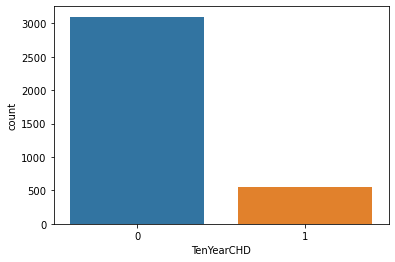

In [148]:
sns.countplot(df.TenYearCHD)
plt.show();

In [5]:
print('CHD to non-CHD ratio:', round(df.TenYearCHD.value_counts()[0] / df.TenYearCHD.value_counts()[1],3))

CHD to non-CHD ratio: 5.567


In [6]:
df.TenYearCHD.value_counts()[1]

557

In [7]:
# Shuffle df
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the CHD in a separate dataset.
CHD_df = shuffled_df.loc[shuffled_df['TenYearCHD'] == 1]

CHD_df.head()

,sysBP,glucose,totChol,cigsPerDay,diaBP,prevalentHyp,age_group,diabetes,BPMeds,gender,TenYearCHD
810,139.0,53.0,247.0,5.0,88.0,0,4,0,0.0,0,1
2131,146.0,80.0,252.0,0.0,92.0,0,4,0,0.0,1,1
765,168.0,68.0,239.0,20.0,102.0,1,4,0,0.0,1,1
2836,139.0,71.0,259.0,0.0,79.0,0,3,0,0.0,1,1
2663,162.5,93.0,177.0,30.0,99.5,1,4,0,0.0,1,1


In [8]:
#Randomly select 492 observations from the non-fraud (majority class)
non_CHD_df = shuffled_df.loc[shuffled_df['TenYearCHD'] == 0].sample(n=557,random_state=42)

# Concatenate both dataframes again
resampled_df = pd.concat([CHD_df, non_CHD_df])

# check new class counts
resampled_df.TenYearCHD.value_counts()



0    557
1    557
Name: TenYearCHD, dtype: int64

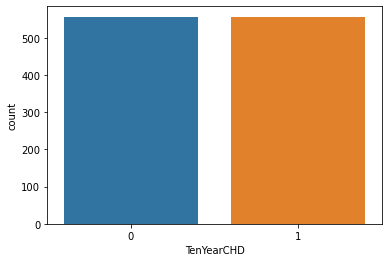

In [149]:
# plot new count
sns.countplot(resampled_df.TenYearCHD)
plt.show();

In [10]:
X = resampled_df.drop(columns=['TenYearCHD', 'diabetes', 'diaBP'])
y = resampled_df.TenYearCHD

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [12]:
#Feature scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Evaluation of different classification model

Here, I will apply various supervise classifcation models and identify the best the model. Following classification models will be evaluated:
1. K-Nearest Neighbor (KNN)
2. Logistic Regression
3. Random Forest
4. Gradient Boost
5. Support vector machine (SVM)
6. Naive Bayes

### K-Nearest neighbor (KNN)

In [13]:
#run KNN model
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [14]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.6766467065868264
Best Parameters: {'n_neighbors': 20}


[[86 62]
 [42 89]]
knn accuracy:  0.6272401433691757


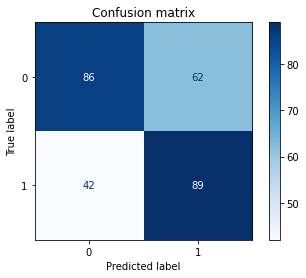

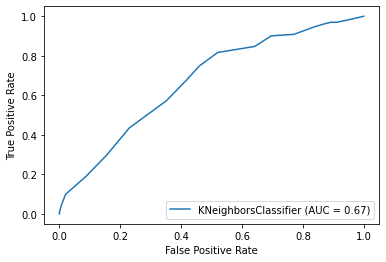

In [28]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train,y_train)
# Predict using model:
y_predict_knn=knn.predict(X_test)

#Confusion matrix:
cnf_matrix = confusion_matrix(y_test, y_predict_knn)
print(cnf_matrix)

#plot confusion matrix
disp = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix")

Accuracy_knn=knn.score(X_test,y_test)
print("knn accuracy: ", Accuracy_knn)

knn_disp= plot_roc_curve(knn,X_test,y_test)

In [36]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.71025641 0.59935897 0.47692308 0.71775223 0.62931034]
Mean cross validation test score: 0.6267202082719324
Mean cross validation train score: 0.7124995396784793
Standard deviation in cv scores: 0.0877036526263431


### Logistic regression

In [16]:
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001,0.01,0.1,1,10,100], 'solver': ['liblinear']}
logreg = LogisticRegression()
logreg_cv= GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [17]:
print("Best Score:" + str(logreg_cv.best_score_))
print("Best Parameters: " + str(logreg_cv.best_params_))

Best Score:0.6826347305389222
Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


[[87 61]
 [38 93]]
logreg accuracy:  0.6451612903225806


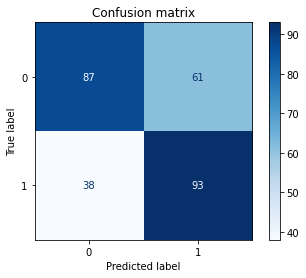

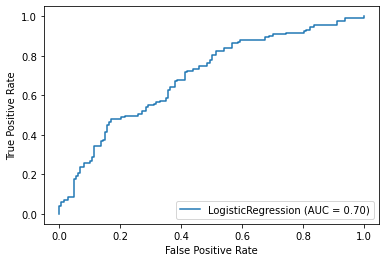

In [38]:
logreg = LogisticRegression(penalty = 'l1', C=100, solver='liblinear')
logreg.fit(X_train,y_train)

# Predict using model:
y_predict_logreg=logreg.predict(X_test)

#Confusion matrix:
cnf_matrix = confusion_matrix(y_test, y_predict_logreg)
print(cnf_matrix)

#plot confusion matrix
disp = plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix")

Accuracy_logreg=logreg.score(X_test,y_test)
print("logreg accuracy: ", Accuracy_logreg)

logreg_disp= plot_roc_curve(logreg,X_test,y_test)

In [40]:
cv_scores_test= cross_val_score(logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.66666667 0.62948718 0.52948718 0.79054917 0.76127321]
Mean cross validation test score: 0.6754926810099223
Mean cross validation train score: 0.7278229201808661
Standard deviation in cv test scores: 0.0939236986892086


### Random forest

In [19]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,6,7,8,9,10,15],
    'n_estimators': [10, 50, 100, 200, 300]
}
rf = RandomForestClassifier()
rf_cv= GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 15],
                         'n_estimators': [10, 50, 100, 200, 300]})

In [20]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.6778443113772455
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 300}


[[85 63]
 [32 99]]
rf accuracy:  0.6594982078853047


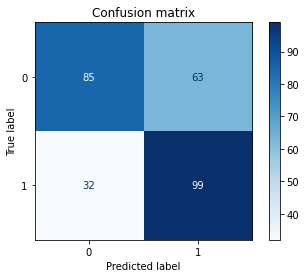

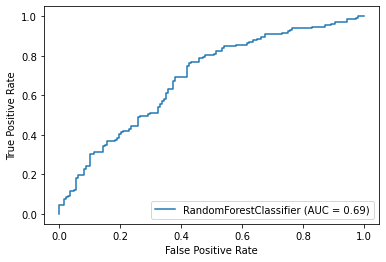

In [41]:
rf = RandomForestClassifier(criterion = 'gini', max_depth=5, n_estimators=300)
rf.fit(X_train,y_train)

# Predict using model:
y_predict_rf=rf.predict(X_test)

#Confusion matrix:
cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)

#plot confusion matrix
disp = plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix")

Accuracy_rf=rf.score(X_test,y_test)
print("rf accuracy: ", Accuracy_rf)

rf_disp= plot_roc_curve(rf,X_test,y_test)

In [42]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.63205128 0.62692308 0.50512821 0.74074074 0.69761273]
Mean cross validation test score: 0.6404912073877591
Mean cross validation train score: 0.7165743840444941
Standard deviation in cv scores: 0.07986401743856682


### Gradient Boosting

In [22]:
param_grid = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000],
              'max_depth': [4, 8, 12, 16, 20], 'min_samples_leaf': [100,150],'max_features': [0.3, 0.1]}
GB = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
GB_cv= GridSearchCV(estimator=GB, param_grid=param_grid, cv=5)
GB_cv.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=10,
                                                  subsample=1),
             param_grid={'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
                         'max_depth': [4, 8, 12, 16, 20],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 250, 500, 750, 1000]})

In [23]:
print("Best Score:" + str(GB_cv.best_score_))
print("Best Parameters: " + str(GB_cv.best_params_))

Best Score:0.6790419161676646
Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 100}


[[ 82  66]
 [ 31 100]]
GB accuracy:  0.6523297491039427


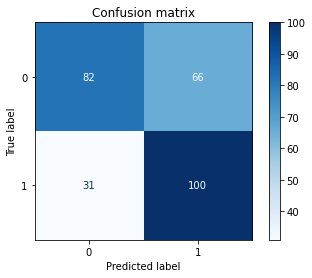

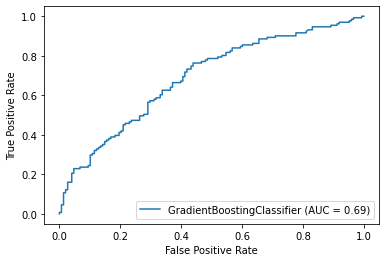

In [31]:
GB = GradientBoostingClassifier(learning_rate=0.05, max_depth= 4, max_features= 0.3, min_samples_leaf= 100, n_estimators= 100)
GB.fit(X_train,y_train)

# Predict using model:
y_predict_GB=GB.predict(X_test)

#Confusion matrix:
cnf_matrix = confusion_matrix(y_test, y_predict_GB)
print(cnf_matrix)

#plot confusion matrix
disp = plot_confusion_matrix(GB, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix")

Accuracy_GB=GB.score(X_test,y_test)
print("GB accuracy: ", Accuracy_GB)

GB_disp= plot_roc_curve(GB,X_test,y_test)

In [44]:
cv_scores_test= cross_val_score(GB,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(GB,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.50897436 0.60192308 0.47884615 0.75542784 0.7367374 ]
Mean cross validation test score: 0.6163817663817663
Mean cross validation train score: 0.7158128207061064
Standard deviation in cv scores: 0.11356120754640606


### Support Vector Machine (SVM)

In [25]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svm = SVC()
svm_cv= GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
svm_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [26]:
print("Best Score:" + str(svm_cv.best_score_))
print("Best Parameters: " + str(svm_cv.best_params_))

Best Score:0.6790419161676647
Best Parameters: {'C': 10, 'kernel': 'linear'}


[[84 64]
 [38 93]]
svm accuracy:  0.6344086021505376


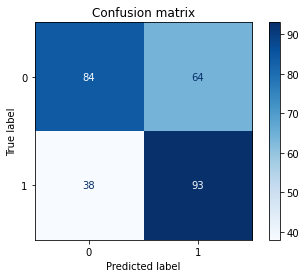

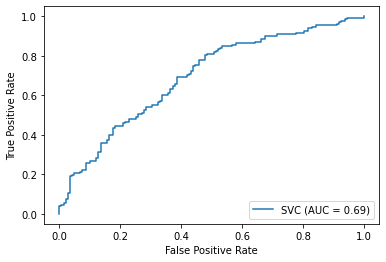

In [45]:
svm = SVC(C=10, kernel="linear")
svm.fit(X_train,y_train)

# Predict using model:
y_predict_scm=svm.predict(X_test)

#Confusion matrix:
cnf_matrix = confusion_matrix(y_test, y_predict_scm)
print(cnf_matrix)

#plot confusion matrix
disp = plot_confusion_matrix(svm, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix")

Accuracy_svm=svm.score(X_test,y_test)
print("svm accuracy: ", Accuracy_svm)

svm_disp= plot_roc_curve(svm,X_test,y_test)

In [46]:
cv_scores_test= cross_val_score(svm,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(svm,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_svm_test= cv_scores_test.mean()
cv_scores_svm_train= cv_scores_train.mean()
cv_scores_std_svm= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_svm_test))
print ('Mean cross validation train score: ' +str(cv_scores_svm_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_svm))

[0.65384615 0.62948718 0.51794872 0.79310345 0.75331565]
Mean cross validation test score: 0.6695402298850575
Mean cross validation train score: 0.7252689369270955
Standard deviation in cv scores: 0.09707391749830886


### Naive Bayes

[[109  39]
 [ 61  70]]
nb accuracy:  0.6415770609318996


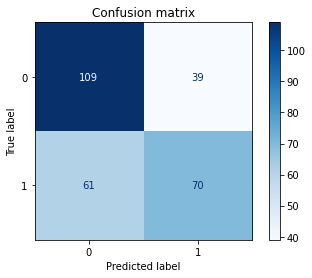

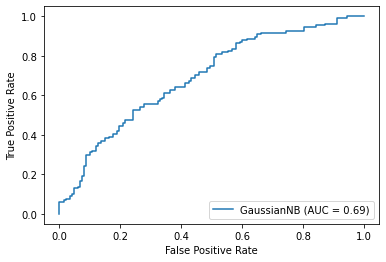

In [47]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)

#Predict using the model:
y_predict_nb=nb.predict(X_test)


#Confusion matrix:
cnf_matrix = confusion_matrix(y_test, y_predict_nb)
print(cnf_matrix)

#plot confusion matrix
disp = plot_confusion_matrix(nb, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix")

Accuracy_nb=nb.score(X_test,y_test)
print("nb accuracy: ", Accuracy_nb)

nb_disp= plot_roc_curve(nb,X_test,y_test)

In [111]:
cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.66025641 0.62564103 0.58333333 0.75351213 0.77851459]
Mean cross validation test score: 0.6802514981825326
Mean cross validation train score: 0.7199169196890327
Standard deviation in cv scores: 0.07456271656442998


## Selection of best model

In [145]:
myLabels = ['KNN','Logistic Regression','Random Forest','Gradient Boost','SVM', 'Naive Bayes']
Accuracy_score = [Accuracy_knn, Accuracy_logreg, Accuracy_rf, Accuracy_GB, Accuracy_svm, Accuracy_nb]
score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model_accuracy_score']) 
score_tab_acc

,Algorithm,Model_accuracy_score
0,KNN,0.627240
1,Logistic Regression,0.645161
2,Random Forest,0.659498
3,Gradient Boost,0.652330
4,SVM,0.634409
5,Naive Bayes,0.641577


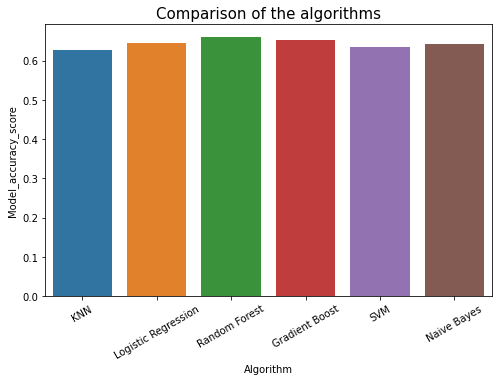

In [151]:
plt.figure(figsize=(8,5))
sns.barplot(x='Algorithm', y='Model_accuracy_score', data=score_tab_acc)
plt.title('Comparison of the algorithms',fontsize=15)
plt.xticks(rotation=30);

In [146]:
score_test= [cv_scores_knn_test, cv_scores_lr_test, cv_scores_rf_test, cv_scores_gbc_test, cv_scores_svm_test, cv_scores_nb_test]
score_train= [cv_scores_knn_train, cv_scores_lr_train, cv_scores_rf_train, cv_scores_gbc_train, cv_scores_svm_train, cv_scores_nb_train]
score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC_train_score', 'ROC-AUC_test_score' ]) 
score_tab

,Algorithm,ROC-AUC_train_score,ROC-AUC_test_score
0,KNN,0.712500,0.626720
1,Logistic Regression,0.727823,0.675493
2,Random Forest,0.716574,0.640491
3,Gradient Boost,0.715813,0.616382
4,SVM,0.725269,0.669540
5,Naive Bayes,0.719917,0.680251


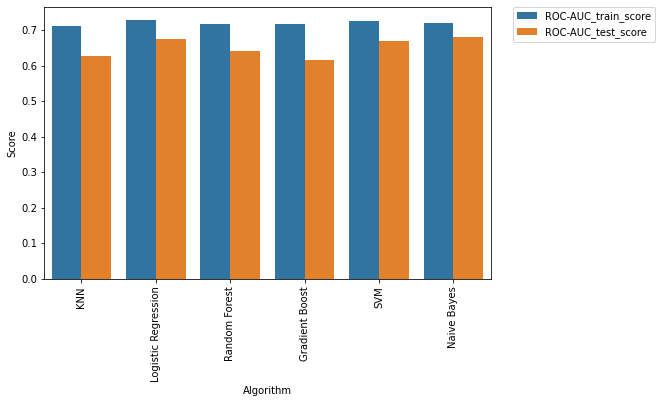

In [144]:
roc = pd.melt(score_tab, id_vars=['Algorithm'], value_vars=['ROC-AUC_train_score', 'ROC-AUC_test_score'])

plt.figure(figsize=(8,5))
sns.barplot(x='Algorithm', y='value', hue='variable', data=roc)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Score')
plt.xticks(rotation=90);

## Data quantity assessment

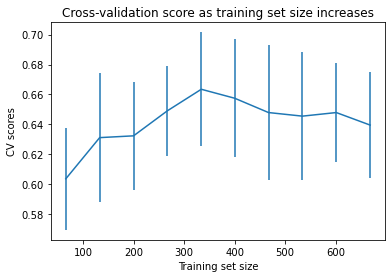

In [155]:
#Assess if the data quantify is enough
fractions = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

#plot
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 40-50.

In [185]:
def plot_learning_curve(estimator, title, X, y, ylim, cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
    plt.legend(loc="best")
    return plt

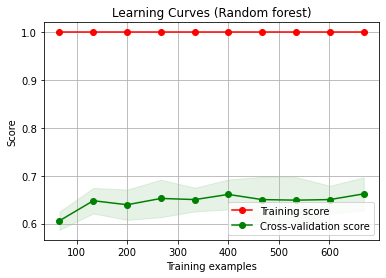

In [186]:
rf=RandomForestClassifier()
title = "Learning Curves (Random forest)"
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], test_size=0.25, random_state=0)
plot_learning_curve(rf, title, X_train, y_train, ylim=(0, 1.1), cv=5, n_jobs=1)
plt.show()